# Project - Grinding Dynamic Simulation Model

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

%matplotlib inline

## Grinding Model Differential Equations

In [2]:
def f_dxdt(t, x, feed, r, b_matrix, d):
    """Ordinary differential equations describing the rate of change of
    mill charge in each size fraction.  This is the 'General Grinding
    Model' described in Molycop Tools spreadsheet (Eq. 3).  Note, t is
    redundant in this case but is included for compatibility with
    numerical solvers which are designed for the general case where dxdt
    can be a function of time also.
    
    Args:
        t (float): Time (mins).
        x (array): Charge load (tons).
        feed (np.ndarray): Mill feed (tons).
        r (array): Breakage rates (selection function).
        b_matrix (array): Breakage matrix (appearance functions).
        d (array): Discharge grate efficiencies.
    """
    A = r*(b_matrix - np.eye(b_matrix.shape[0])) - np.diag(d)
    return feed + A @ x

In [3]:
def solve(t, x0, dxdt, timestep_size, args, method='Radau'):
    """Estimates x at time t + timestep by starting at x0 and
    using the derivate function dxdt to numerically solve the
    initial value problem.
    
    Args:
        t: (float): Initial time.
        x0 (array): Initial x at time t (i.e. x[t]). 
        dxdt (function): Function which returns the derivative of x.
        timestep_size (float): Timestep to increment by.
        args (list): Additional arguments to pass to dxdt.
    
    Returns:
        x2 (array): State vector at time t + timestep_size.
    """
    t2 = t + timestep_size
    sol = solve_ivp(dxdt, t_span=[t, t2], y0=x0, method=method,
                    args=args)
    assert sol.status == 0, "Solver failed."

    return sol.y[:, -1]

## Unit Tests

In [4]:
# Calculation example with 3 size intervals

# Feed rates
feed = np.array([ 2,  1,  0])

# Discharge rate function
d_max = 0.2  # Transport to grate
c = np.array([  0, 0.5, 1.0])  # Grate classification function
d = d_max * c

# Breakage rates
r = np.array([0.2, 0.25, 0.1])

assert all((r + d) <= 1)

# Initial charge
x0 = np.array([30, 30, 30])

# Breakage matrix
b_matrix = np.array([
    [  0,   0,   0],
    [0.5,   0,   0],
    [0.5, 1.0,   0]
])

assert all(sum(b_matrix)[:-1] == 1)

n_sizes = x0.shape[0]
assert feed.shape == (n_sizes, )
assert d.shape == (n_sizes, )
assert r.shape == (n_sizes, )

In [5]:
# Test derivative calculations
t = 0
dxdt = f_dxdt(t, x0, feed, r, b_matrix, d)
dxdt

array([-4. , -6.5,  1.5])

In [6]:
# Rate of change of charge - size 1
dxdt1_true = (feed[0] - x0[0] * r[0]) * (1 - d[0])
assert dxdt[0] == dxdt1_true
dxdt[0], dxdt1_true

(-4.0, -4.0)

In [10]:
breakage = x0 * r
discharge = x0 * d

In [11]:
# Rate of change of charge - size 2
dxdt2_true = (feed[1]
    + breakage[0] * b_matrix[1, 0]
    - breakage[1]
    - discharge[1]
)
assert dxdt[1] == dxdt2_true
dxdt[1], dxdt2_true

(-6.5, -6.5)

In [13]:
# Rate of change of charge - size 3
dxdt3_true = (feed[2]
    + breakage[0] * b_matrix[2, 0]
    + breakage[1] * b_matrix[2, 1]
    - breakage[2]
    - discharge[2]
)
assert np.isclose(dxdt[2], dxdt3_true)
dxdt[2], dxdt3_true

(1.4999999999999982, 1.5)

In [14]:
# Test solver
t = 0
timestep_size = 0.5
x1 = solve(t, x0, f_dxdt, timestep_size, args=[feed, r, b_matrix, d])
x1

array([28.09674836, 26.97283772, 30.46615437])

In [15]:
# Test solution with difference estimates
t = 0
timestep_size = 0.01  # Small timestep
x1 = solve(t, x0, f_dxdt, timestep_size, args=[feed, r, b_matrix, d])
dxdt_est = (x1 - x0) / timestep_size
dxdt_true = f_dxdt(t, x0, feed, r, b_matrix, d)

assert np.isclose(dxdt_est, dxdt_true, atol=0.05).all()

print(dxdt_est, dxdt_true)

[-3.99600267 -6.4906346   1.4876465 ] [-4.  -6.5  1.5]


In [16]:
# Simulate over time
nt = 50
timestep_size = 0.5

# Constant feedrate
feed_rates = np.repeat(feed.reshape(1,-1), nt, axis=0)

# Initialize variables
x = np.zeros((nt, n_sizes))
discharge_rates = np.zeros((nt, n_sizes))
x[0] = x0

t = np.arange(nt) * timestep_size
for k in range(1, nt):
    feed = feed_rates[k]
    x[k, :] = solve(t[k], x[k-1], f_dxdt, timestep_size, args=[feed, r, b_matrix, d])
    discharge_rates[k] = feed + x[k-1] - x[k]

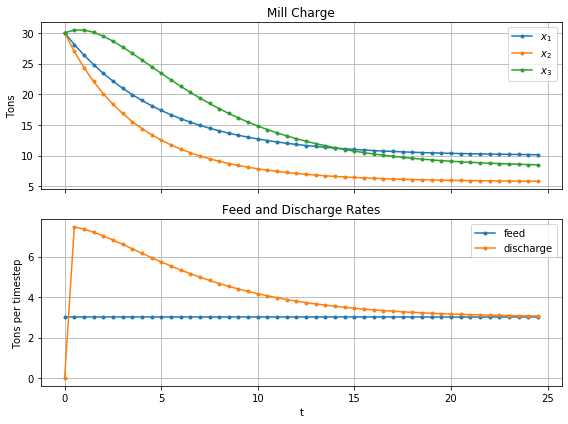

In [17]:
fig, axes = plt.subplots(2, 1, figsize=(8,6), sharex=True)

ax = axes[0]
for i in range(3):
    ax.plot(t, x[:,i], '.-', label=f'$x_{i+1}$')
ax.set_title('Mill Charge')
ax.set_ylabel('Tons')
ax.grid()
ax.legend()

ax = axes[1]
ax.plot(t, feed_rates.sum(axis=1), '.-', label='feed')
ax.plot(t, discharge_rates.sum(axis=1), '.-', label='discharge')
ax.set_title('Feed and Discharge Rates')
ax.set_xlabel('t')
ax.set_ylabel('Tons per timestep')
ax.grid()
ax.legend()

plt.tight_layout()
plt.show()